## Dependencies
<a id='library'></a>

In [1]:
!rm udf.py; ln -s ../src/udf.py udf.py

In [1]:
import udf
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import inflection

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_rows = 30
pd.options.display.max_columns = 27

seed = 0
colors = ['#99d594', '#D53E4F', '#FC8D59']
path = "../input/"

## 1. Load the dataset
<a id='ld'></a>

In [2]:
full_train = udf.load_dataset(f"{path}train.csv")
display(full_train.shape, full_train.head(2))

(478741, 27)

,accident_id,police_force,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_(district),local_authority_(highway),1st_road_class,1st_road_number,road_type,speed_limit,2nd_road_class,2nd_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,state,postcode,country
0,1,34,2,1,19/12/12,7,13:20,344,E10000032,4,395,Single carriageway,30,-1,0,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,None,1,Yes,England,OX3 9UP,United Kingdom
1,2,5,2,1,02/11/12,4,7:53,102,E09000026,3,13,One way street,30,-1,0,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Raining without high winds,Dry,None,None,1,No,England,S35 4EZ,United Kingdom


## 2. Create new columns: Accident Risk Index

In [3]:
new_columns = udf.acc_risk_idx(full_train)
new_columns.head(2)

,postcode,accident_count,total_casualties,accident_risk_index
0,LE6 0GF,27,48,1.778
1,MK10 9AP,26,46,1.769


In [4]:
full_train = udf.merge_dataset(full_train, new_columns)
display(full_train.head(2))
#full_train.to_csv("../input/train_mod.csv", index=False)

,accident_id,police_force,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_(district),local_authority_(highway),1st_road_class,1st_road_number,road_type,speed_limit,...,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,state,postcode,country,accident_risk_index
0,1,34,2,1,19/12/12,7,13:20,344,E10000032,4,395,Single carriageway,30,...,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,None,1,Yes,England,OX3 9UP,United Kingdom,1.833
1,114321,1,1,1,26/04/12,4,13:30,728,S12000041,6,5,Single carriageway,30,...,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Wet/Damp,None,None,1,Yes,Cymru / Wales,OX3 9UP,United Kingdom,1.833


## 3. Exploratory Data Analysis
<a id='eda'>
</a>

### 3.1 Selected variables

In [5]:
variables = [
       'accident_id', 'number_of_vehicles', 'date',
       'day_of_week', 'time', 
       'road_type', 'speed_limit', 
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area',
       'did_police_officer_attend_scene_of_accident', 'postcode',
       'number_of_casualties', 
       'accident_risk_index'
]

full_train = udf.load_dataset("../input/train_mod.csv")[variables]
full_train.head(3)

,accident_id,number_of_vehicles,date,day_of_week,time,road_type,speed_limit,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,postcode,number_of_casualties,accident_risk_index
0,1,2,19/12/12,7,13:20,Single carriageway,30,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,None,1,Yes,OX3 9UP,1,1.833
1,114321,1,26/04/12,4,13:30,Single carriageway,30,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Wet/Damp,None,None,1,Yes,OX3 9UP,1,1.833
2,151919,2,17/02/12,1,14:40,Dual carriageway,70,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,2,Yes,OX3 9UP,3,1.833


### 3.2 Duplicate data

In [7]:
full_train.duplicated().any()

False

There are no duplicated data.

### 3.3 Missing value and data type

In [8]:
udf.missing_values(full_train).sort_values(by='unique_values').reset_index(drop=True)

,variable,unique_values,pandas_dtype,missing_value,%_missing_values
0,did_police_officer_attend_scene_of_accident,2,object,0,0.000
1,urban_or_rural_area,2,int64,0,0.000
2,pedestrian_crossing_human_control,3,object,0,0.000
3,number_of_vehicles,4,int64,0,0.000
4,light_conditions,5,object,0,0.000
5,number_of_casualties,5,int64,0,0.000
6,road_surface_conditions,5,object,452,0.094
7,road_type,6,object,0,0.000
8,speed_limit,6,int64,0,0.000
9,pedestrian_crossing_physical_facilities,6,object,0,0.000


Observations:
* Most of variables do not have missing values except for road_surface_conditions, time and special_conditions_at_site which have missing values less than 0.1% data.
* Due to missing value is very small compared to the size of data, I consider to drop them.
* There are 1 target and 17 features, consisting of 2 unique identifier, 3 time variables, 10 categorical and 3 numerical variables that will be used for analysis dan modeling.
* Two of time variables, date and time, are still in object type.

In [6]:
full_train = full_train.dropna()
#full_train.to_csv("full_train.csv", index=False)

In [10]:
unique_identifier = ['postcode', 'accident_id']
time_variables = ['date', 'day_of_week', 'time']
categorical = [
    'road_type', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities',
    'light_conditions', 'weather_conditions', 'road_surface_conditions', 
    'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident'
]
numerical = [
    'number_of_vehicles', 'speed_limit', 'number_of_casualties'
]
target = 'accident_risk_index'

### 3.4 Target variables: Accident risk index

In [11]:
udf.num_descriptive_analysis(full_train[[target]])

variable,accident_risk_index
mean,1.460
std,0.360
min,1.000
25%,1.220
50%,1.420
75%,1.670
max,5.000


variable,accident_risk_index
range,4.000
IQR,0.440
mode,1.000
kurtosis,6.480
skewness,1.530


Observations:
* The target variable has a range from 1 to 5 with median is 1.42.
* 75% of data are below 1.67

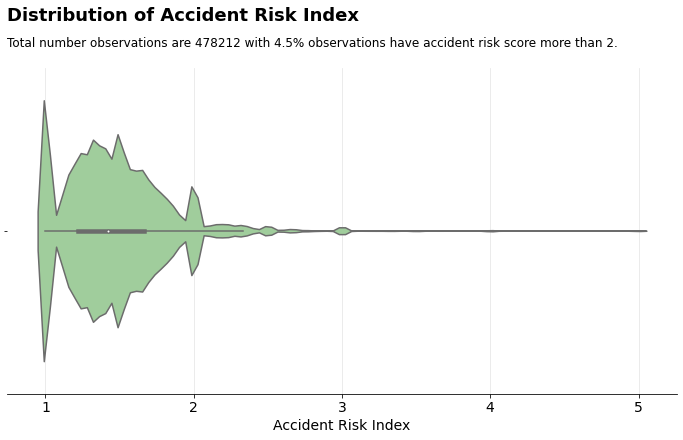

In [13]:
var = 'accident_risk_index'
udf.single_violinplot(full_train, var)
plt.suptitle(f"Distribution of {inflection.titleize(var)}", ha='left', x=0.125, y=1.02, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]} with 4.5% observations have accident risk score more than 2.\n", loc='left')
plt.show()

Observations:
* Approximately 95% of accident risk index belong to range 1 to 2.
* To weight the number of casualties more, probably the best way are to create weighted accident risk accidents
* Which postcode region have higher index? list top 10

### 3.5 Numerical Variables

#### 3.5.1 Descriptive Analysis

In [14]:
udf.num_descriptive_analysis(full_train[numerical])

variable,number_of_vehicles,speed_limit,number_of_casualties
mean,1.750,37.020,1.460
std,0.630,12.840,0.820
min,1.000,20.000,1.000
25%,1.000,30.000,1.000
50%,2.000,30.000,1.000
75%,2.000,40.000,2.000
max,4.000,70.000,5.000


variable,number_of_vehicles,speed_limit,number_of_casualties
range,3,50,4
IQR,1.000,10.000,1.000
mode,2,30,1
kurtosis,1.140,0.230,4.340
skewness,0.620,1.320,2.050


Observations:
* All of numerical variables are evenly spaced, so the better way to visualize them by using barplot.

#### 3.5.2 Distribution Plot

##### Number of Vehicles

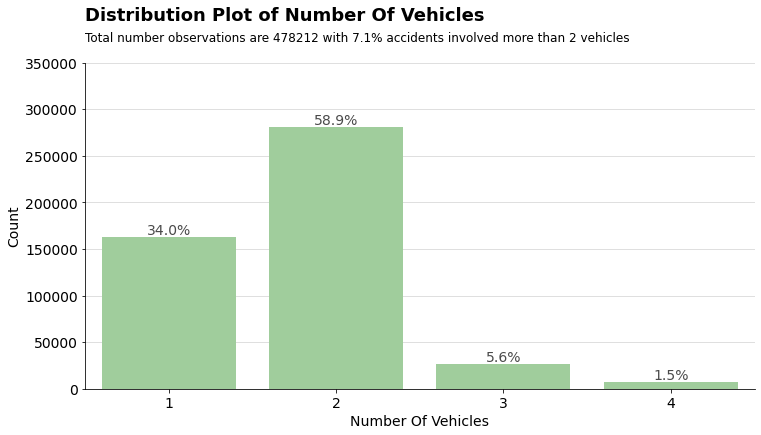

In [15]:
var = 'number_of_vehicles'
udf.single_countplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]} with 7.1% accidents involved more than 2 vehicles\n", loc='left')
plt.show()

Observations:
* Number of vehicles that involved on accident are varied from 1 to 4.
* Approximately 93% of accidents involved at least one vehicle.

##### Speed Limit

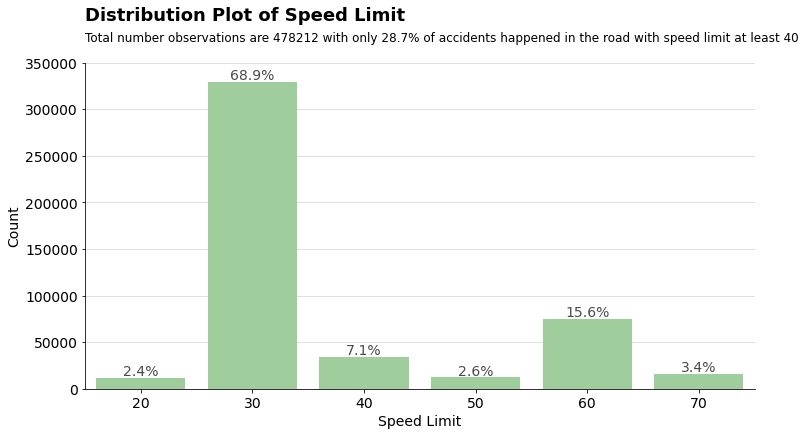

In [16]:
var = 'speed_limit'
udf.single_countplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]} with only 28.7% of accidents happened in the road with speed limit at least 40\n", loc='left')
plt.show()

Observations:
* 68.9% of accidents occured in the road with speed limit 30, while only 3.4% accidents occured with speed limit 70.

##### Number of Casualties

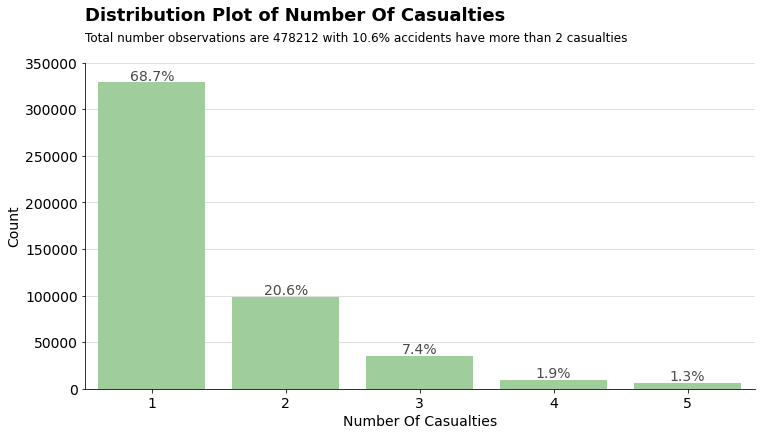

In [17]:
var = 'number_of_casualties'
udf.single_countplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]} with 10.6% accidents have more than 2 casualties\n", loc='left')
plt.show()

Observations:
* Around 68% accidents caused only one casualty, while almost 21% accidents caused two casualties.

#### 3.5.3 Correlation Heatmap

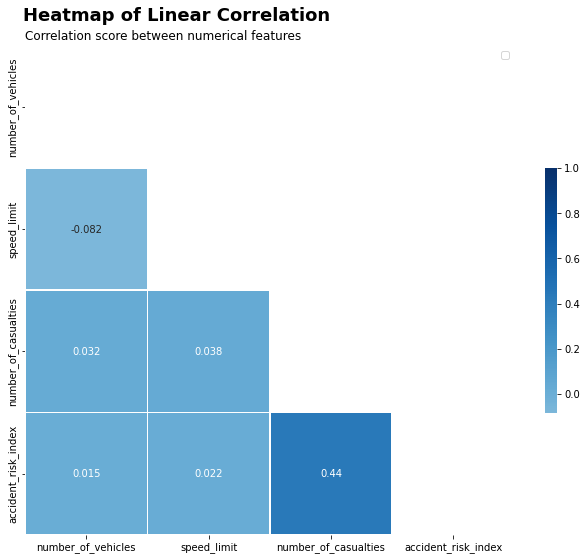

In [18]:
num_vars = numerical.copy()
num_vars.append(target)

df = full_train[num_vars].copy()
corr = df.corr()
mask = np.triu(np.ones_like(corr))

fig, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .5}, 
            annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax.set_axisbelow(True)

plt.legend(['Pearson Correlation'])
plt.suptitle("Heatmap of Linear Correlation", ha='left', x=0.125, y=0.94, fontsize=18, fontweight='bold')
plt.title("Correlation score between numerical features", loc='left')
plt.show()

Observations:
* Although number of casualties are dependent to accident risk index, the linear correlation shows that between variables do not have a strong correlation (only 0.44). 
* Number of vehicles and speed limit have very weak correlation to accident risk index with score less than 0.01.

### 3.6 Categorical Variables

#### 3.6.1 Descriptive Analysis

map the urban or rural area variable.

In [19]:
def mapped_area(df):
    df = df.copy()
    df['urban_or_rural_area'] = df['urban_or_rural_area'].map({
        1: "urban",
        2: "rural",
        np.nan: "unknown"
    })
    return df

full_train = mapped_area(full_train)

In [20]:
cat_desc = full_train[categorical].describe().T.reset_index()
cat_desc['percentage'] = cat_desc['freq'] * 100 / full_train.shape[0]
cat_desc

,index,count,unique,top,freq,percentage
0,road_type,478212,6,Single carriageway,372093,77.809
1,pedestrian_crossing_human_control,478212,3,None within 50 metres,454531,95.048
2,pedestrian_crossing_physical_facilities,478212,6,No physical crossing within 50 meters,404057,84.493
3,light_conditions,478212,5,Daylight: Street light present,377470,78.934
4,weather_conditions,478212,9,Fine without high winds,379038,79.261
5,road_surface_conditions,478212,5,Dry,365786,76.490
6,special_conditions_at_site,478212,8,None,427412,89.377
7,carriageway_hazards,478212,6,None,459079,95.999
8,urban_or_rural_area,478212,2,urban,286216,59.851
9,did_police_officer_attend_scene_of_accident,478212,2,Yes,390578,81.675


#### 3.6.2 Distribution Plot

##### Road Type

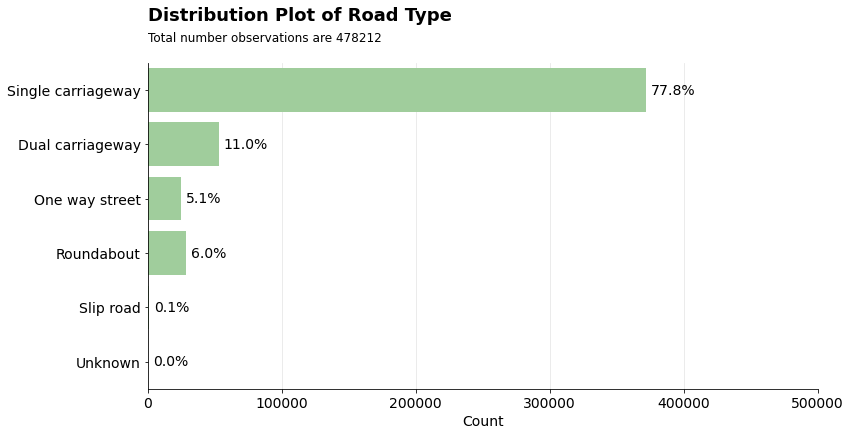

In [21]:
var = 'road_type'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Pedestrian Crossing Human Control

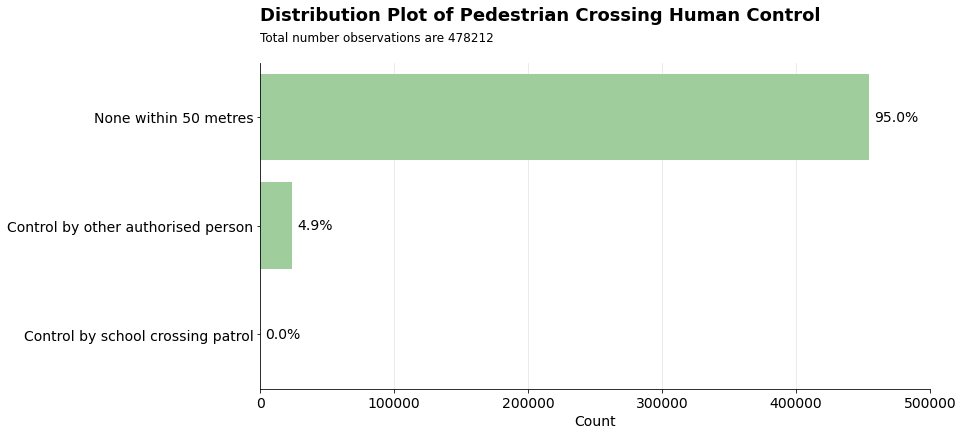

In [22]:
var = 'pedestrian_crossing_human_control'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Pedestrian Crossing Physical Facilities

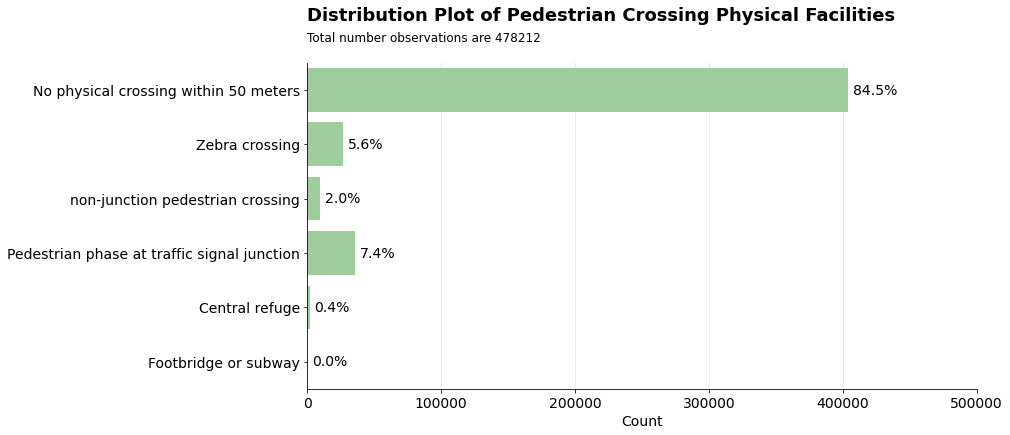

In [23]:
var = 'pedestrian_crossing_physical_facilities'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Light Conditions

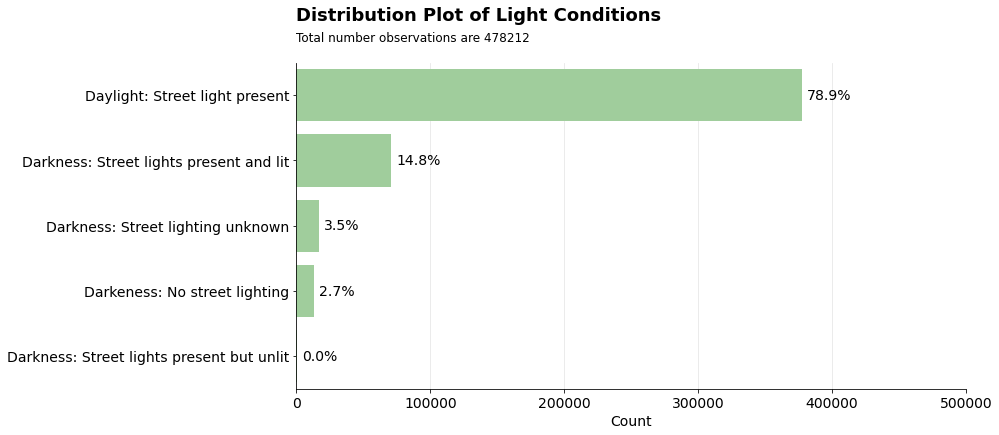

In [24]:
var = 'light_conditions'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Weather Conditions

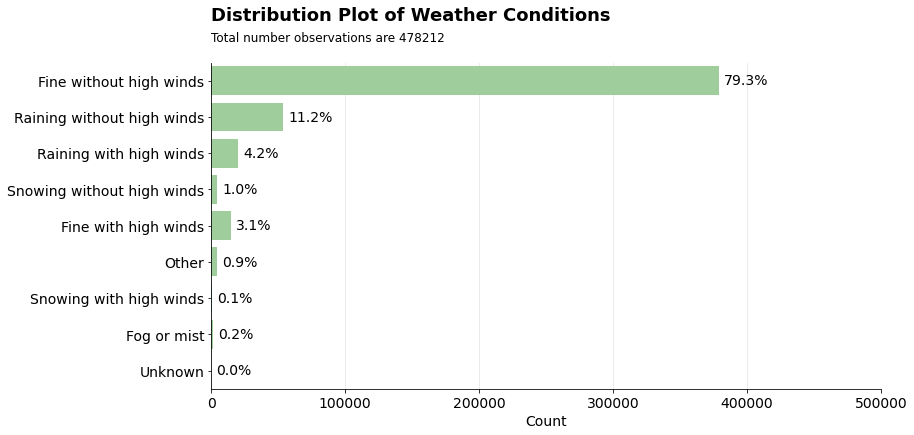

In [25]:
var = 'weather_conditions'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Road Surface Conditions

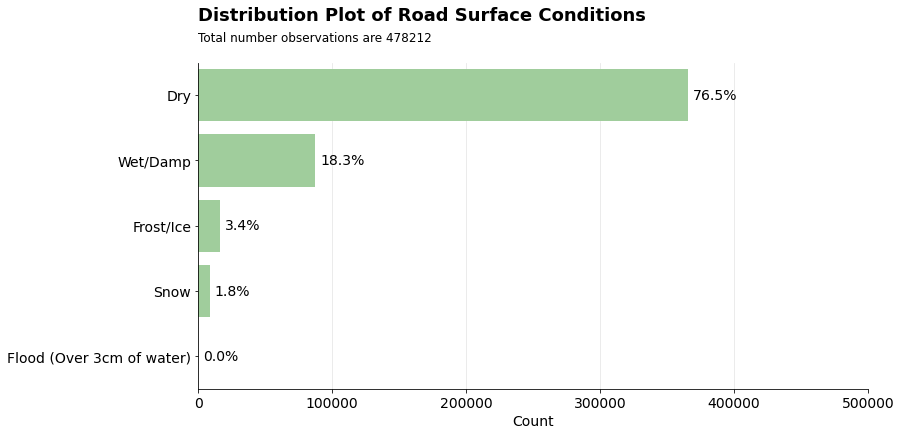

In [26]:
var = 'road_surface_conditions'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Special Conditions at Site

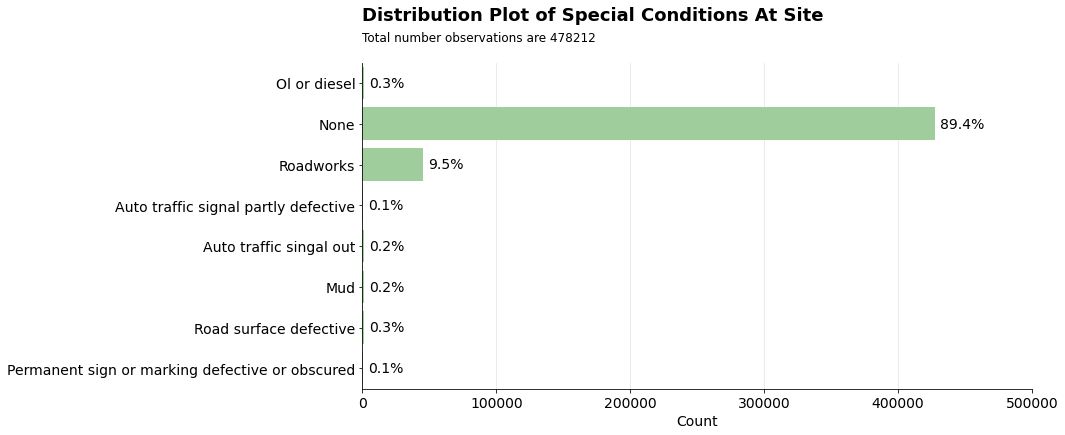

In [27]:
var = 'special_conditions_at_site'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Carriageway Hazards

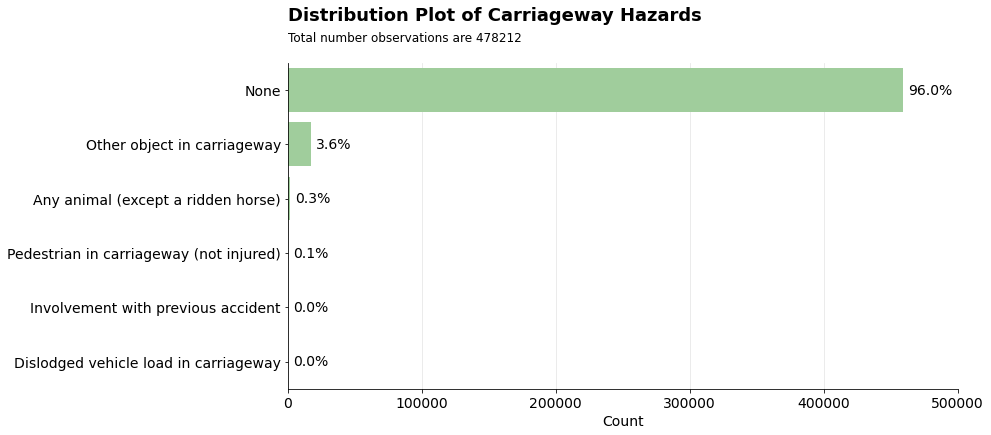

In [28]:
var = 'carriageway_hazards'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Urban or Rural Area

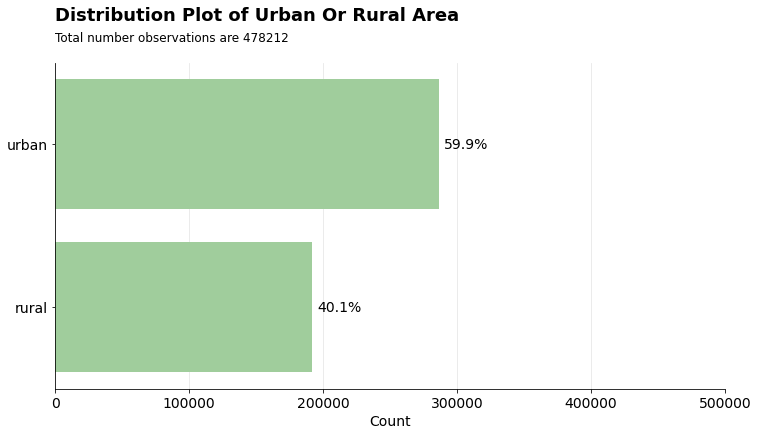

In [29]:
var = 'urban_or_rural_area'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

##### Did Police Officer Attend Scene of Accident

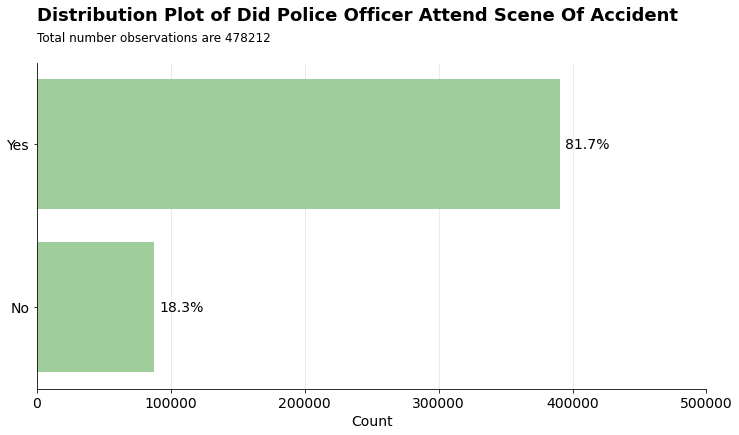

In [30]:
var = 'did_police_officer_attend_scene_of_accident'
udf.single_vcountplot(full_train, var)
plt.suptitle(f"Distribution Plot of {inflection.titleize(var)}", ha='left', x=0.125, y=1.01, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {full_train.shape[0]}\n", loc='left')
plt.show()

#### 3.6.3 Quantitative Analysis

In [31]:
def anova_test():
    def single_anova_test(df, feature='road_type'):
        df = df.copy()

        groups = []
        for val in list(df[feature].unique()):
            road_type_group = df.groupby(feature).get_group(val).reset_index(drop=True)
            groups.append(road_type_group['accident_risk_index'])

        return stats.f_oneway(*groups)
    
    results = pd.DataFrame()
    results.loc[:, 'categorical'] = categorical
    results.loc[:, 'numerical'] = target
    results.loc[:, 'f_statistic'] = np.nan
    results.loc[:, 'p_value'] = np.nan
    
    for i, var in enumerate(categorical):
        f_stats, p_value = single_anova_test(full_train, feature=var)
        results.loc[i, 'f_statistic'] = f_stats
        results.loc[i, 'p_value'] = p_value
    
    return results.sort_values(by='p_value')

anova_test()

,categorical,numerical,f_statistic,p_value
8,urban_or_rural_area,accident_risk_index,249.797,0.000
0,road_type,accident_risk_index,31.943,0.000
5,road_surface_conditions,accident_risk_index,19.352,0.000
3,light_conditions,accident_risk_index,16.906,0.000
9,did_police_officer_attend_scene_of_accident,accident_risk_index,25.179,0.000
2,pedestrian_crossing_physical_facilities,accident_risk_index,4.719,0.000
4,weather_conditions,accident_risk_index,3.564,0.000
1,pedestrian_crossing_human_control,accident_risk_index,2.822,0.059
6,special_conditions_at_site,accident_risk_index,1.759,0.091
7,carriageway_hazards,accident_risk_index,0.268,0.931


Observations:
* The above table displays the results of the ANOVA test between target variable (numerical), which is `accident_risk_index` and categorical features. It also shows significant dependence between `accident_risk_index` and almost categorical features except the following features with a significance level set at 0.05:
    * `pedestrian_crossing_human_control`
    * `special_conditions_at_site`
    * `carriageway_hazards`

### 3.7 Time Variables

In [11]:
full_train = pd.read_csv(f"{path}sorted_train.csv")
full_train.head(1)

,accident_id,number_of_vehicles,date,day_of_week,time,road_type,speed_limit,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,postcode,number_of_casualties,accident_risk_index,day_of_year,month
0,21606,3,2012-01-01,1,03:30:00,Single carriageway,30,Control by other authorised person,No physical crossing within 50 meters,Daylight: Street light present,Raining without high winds,Dry,Roadworks,None,1,Yes,PO9 1JT,1,1.750,1,1


#### 3.7.1 Number of Accidents per minute

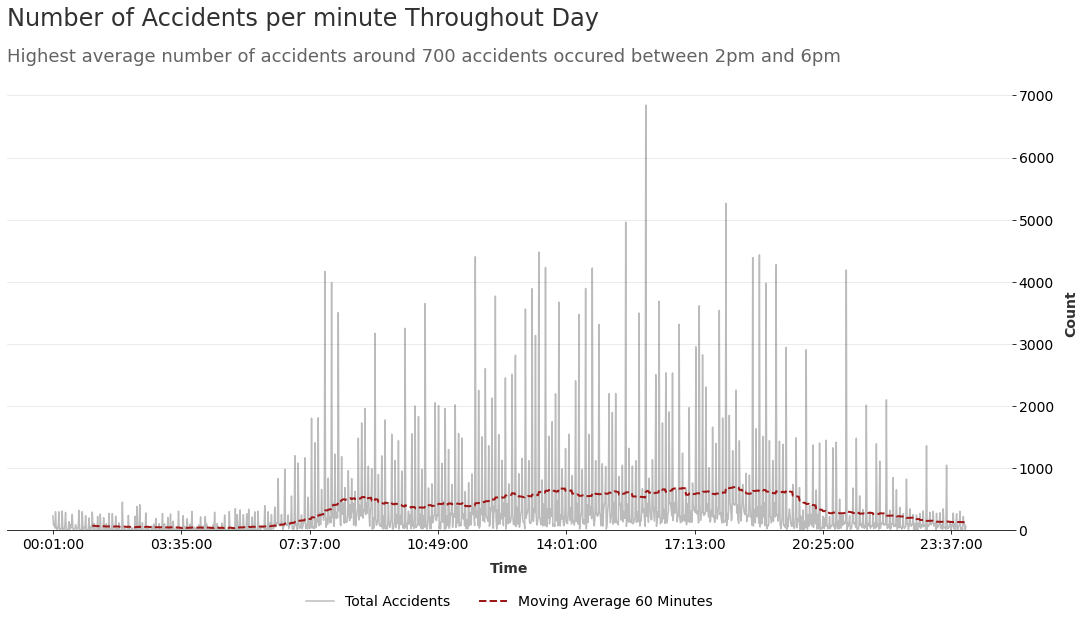

In [177]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = full_train.groupby('time').count().reset_index()[['time', 'accident_id']]
moving_avg = data.rolling(60).mean()['accident_id']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
fig, ax = plt.subplots(figsize=(18, 8))

line = ax.plot(
    data['time'], data['accident_id'],
    color=colors_dark[0],
    alpha=0.3,
    label='Total Accidents', 
)

mov_avg = ax.plot(
    data['time'], moving_avg.values,
    linestyle='--',
    color=colors_red[2],
    linewidth=2,
    label='Moving Average 60 Minutes'
)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

for location in ['top', 'left', 'right']:
    ax.spines[location].set_visible(False)

ax.grid(axis='y', alpha=0.3)

ax.xaxis.grid(True, which='minor')
ax.xaxis.set_major_locator(MultipleLocator(192))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=14)
ax.set_ylabel("Count", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[1])
ax.set_xlabel("Time", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[1])

ax.set_ylim(0, 7001)
ax.set_yticklabels(np.arange(0, 7001, 1000), fontsize=14)
plt.xticks(fontsize=14)

ax.text(
    s="Number of Accidents per minute Throughout Day",
    fontsize=24,
    color=colors_dark[1],
    x=xmin, y=ymax*1.13
)

ax.text(
    s=f"Highest average number of accidents around 700 accidents occured between 2pm and 6pm",
    fontsize=18,
    color=colors_dark[2],
    x=xmin, y=ymax*1.05
)

plt.show()

#### 3.7.2 Total Accidents throughout year

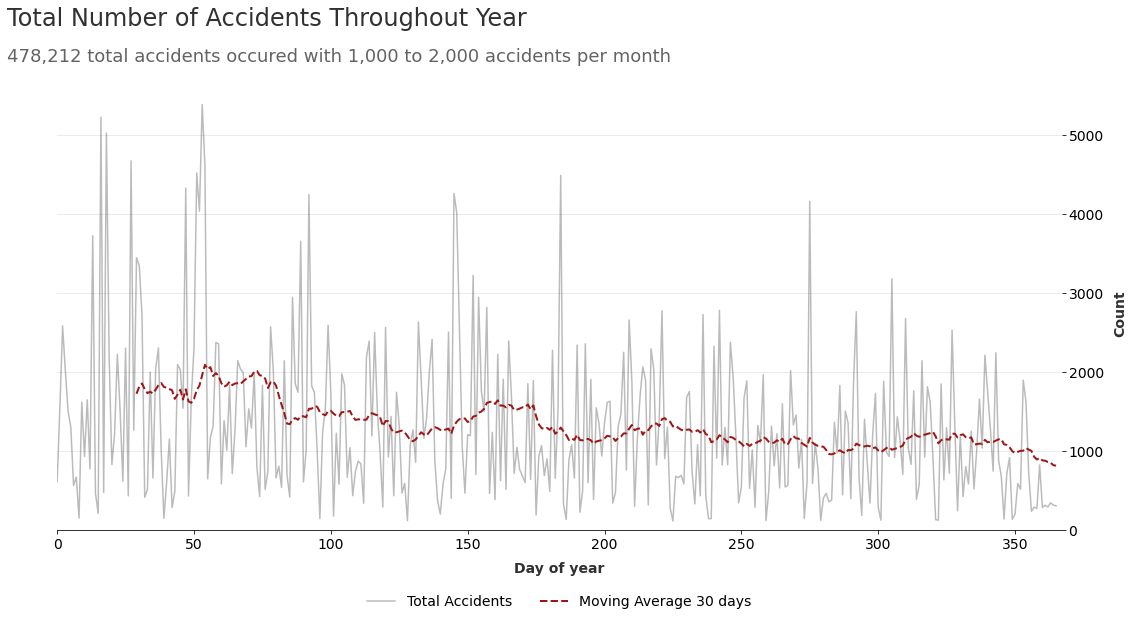

In [194]:
data = full_train.groupby('day_of_year').count().reset_index()[['accident_id']]
moving_avg = data.rolling(30).mean()['accident_id']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
fig, ax = plt.subplots(figsize=(18, 8))

line = ax.plot(
    data.index, data.values,
    color=colors_dark[0],
    alpha=0.3,
    label='Total Accidents',
)

mov_avg = ax.plot(
    moving_avg.index, moving_avg.values,
    linestyle='--',
    color=colors_red[2],
    linewidth=2,
    label='Moving Average 30 days'
)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

for location in ['top', 'left', 'right']:
    ax.spines[location].set_visible(False)

ax.grid(axis='y', alpha=0.3)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=14)
ax.set_ylabel("Count", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[1])
ax.set_xlabel("Day of year", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[1])

ax.set_xlim(0, 367)
ax.set_xticklabels(np.arange(0, 367, 50), fontsize=14)

ax.set_ylim(0, 5500)
ax.set_yticklabels(np.arange(0, 6001, 1000), fontsize=14)

ax.text(
    s="Total Number of Accidents Throughout Year",
    fontsize=24,
    color=colors_dark[1],
    x=xmin, y=ymax*1.13
)

ax.text(
    s=f"{full_train.shape[0]:,} total accidents occured with 1,000 to 2,000 accidents per month",
    fontsize=18,
    color=colors_dark[2],
    x=xmin, y=ymax*1.05
)

plt.show()

#### 3.7.3 Number of Accidents per day of week

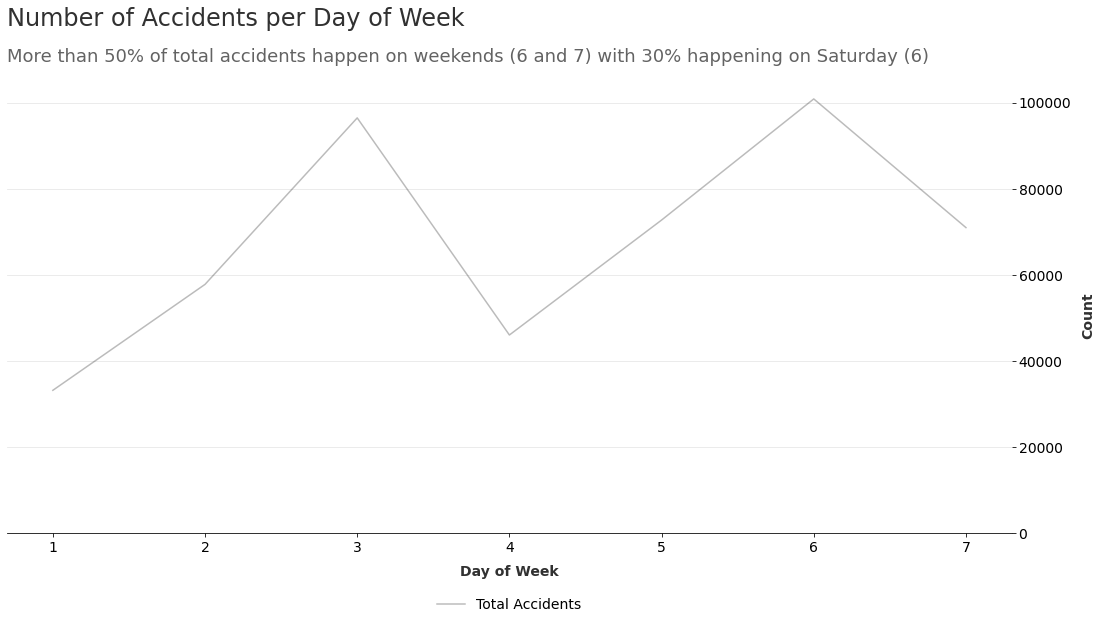

In [18]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = full_train.groupby('day_of_week').count().reset_index()[['day_of_week', 'accident_id']]
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
fig, ax = plt.subplots(figsize=(18, 8))

line = ax.plot(
    data['day_of_week'], data['accident_id'],
    color=colors_dark[0],
    alpha=0.3,
    label='Total Accidents', 
)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

for location in ['top', 'left', 'right']:
    ax.spines[location].set_visible(False)

ax.grid(axis='y', alpha=0.3)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=14)
ax.set_ylabel("Count", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[1])
ax.set_xlabel("Day of Week", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[1])

ax.set_ylim(0, 101001)
ax.set_yticklabels(np.arange(0, 100001, 20000), fontsize=14)
plt.xticks(fontsize=14)

ax.text(
    s="Number of Accidents per Day of Week",
    fontsize=24,
    color=colors_dark[1],
    x=xmin, y=ymax*1.13
)

ax.text(
    s=f"More than 50% of total accidents happen on weekends (6 and 7) with 30% happening on Saturday (6)",
    fontsize=18,
    color=colors_dark[2],
    x=xmin, y=ymax*1.05
)

plt.show()